# Light-cone construction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tools21cm as t2c

import warnings
warnings.filterwarnings("ignore")

Here we create fake dataset of coeval cubes where there are growing spherical HII regions. The radius is defined using the following form:

$r = 20~e^{-(z-7)/3}$

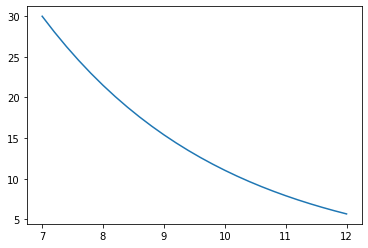

In [2]:
zs_set = np.arange(7,12.1,0.2)

r_hii = lambda x: 30*np.exp(-(x-7.)/3)
plt.plot(zs_set, r_hii(zs_set))

In [3]:
def fake_simulator(ncells, z):
    cube = np.zeros((ncells,ncells,ncells))
    xx, yy, zz = np.meshgrid(np.arange(ncells), np.arange(ncells), np.arange(ncells), sparse=True)
    # rr2 = xx**2+yy**2+zz**2
    r  = r_hii(z)
    r2 = (xx-ncells/2)**2+(yy-ncells/2)**2+(zz-ncells/2)**2
    xx0, yy0, zz0 = int(ncells/2), int(ncells/2), int(ncells/2)
    cube0 = np.zeros((ncells,ncells,ncells))
    cube0[r2<=r**2] = 1
    cube0 = np.roll(np.roll(np.roll(cube0, -xx0, axis=0), -yy0, axis=1), -zz0, axis=2)
    # Bubble 1
    xx1, yy1, zz1 = int(ncells/2), int(ncells/2), int(ncells/2)
    cube = cube+np.roll(np.roll(np.roll(cube0, xx1, axis=0), yy1, axis=1), zz1, axis=2)
    # Bubble 2
    xx2, yy2, zz2 = int(ncells/2), int(ncells/4), int(ncells/16)
    cube = cube+np.roll(np.roll(np.roll(cube0, xx2, axis=0), yy2, axis=1), zz2, axis=2)
    # Bubble 3
    xx3, yy3, zz3 = int(ncells/2+10), int(-ncells/4), int(-ncells/32)
    cube = cube+np.roll(np.roll(np.roll(cube0, xx3, axis=0), yy3, axis=1), zz3, axis=2)
    return cube

Visualizing the fake coeval cubes of growing HII regions.

Text(0.5, 1.0, 'z=7')

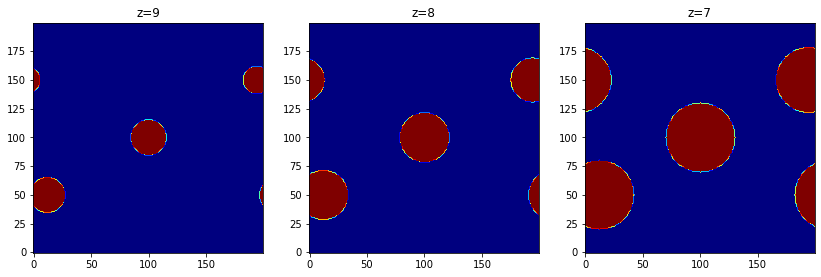

In [4]:
z0 = 9; c0 = fake_simulator(200,z0)
z1 = 8; c1 = fake_simulator(200,z1)
z2 = 7; c2 = fake_simulator(200,z2)

fig, axs = plt.subplots(1,3, figsize=(14, 5))
axs[0].imshow(c0[100,:,:], origin='lower', cmap='jet')
axs[0].set_title('z={}'.format(z0))
axs[1].imshow(c1[100,:,:], origin='lower', cmap='jet')
axs[1].set_title('z={}'.format(z1))
axs[2].imshow(c2[100,:,:], origin='lower', cmap='jet')
axs[2].set_title('z={}'.format(z2))

In [5]:
zs_set = np.arange(7,12.1,0.2)
coeval_set = {}
for zi in tqdm(zs_set):
    coeval_set['{:.2f}'.format(zi)] = fake_simulator(200,zi)

100%|██████████| 26/26 [00:07<00:00,  3.29it/s]


### Preparing for light-cone construction

To construct light-cones, one can use `make_lightcone` function. The parameter `filenames` takes a list such that each element from this list can be provided to the `reading_function` and get the coeval cubes for the corresponding redshift (given through a list to the parameter `file_redshifts`).

In [6]:
def reading_function(name):
    return coeval_set[name]

In [7]:
filenames = ['{:.2f}'.format(zi) for zi in zs_set]
file_redshifts = zs_set

xf_lc, zs_lc = t2c.make_lightcone(
                            filenames,
                            z_low=None,
                            z_high=None,
                            file_redshifts=file_redshifts,
                            cbin_bits=32,
                            cbin_order='c',
                            los_axis=2,
                            raw_density=False,
                            interpolation='linear',
                            reading_function=reading_function,
                            box_length_mpc=200,
                        )


Making lightcone between 7.000000 < z < 11.999359


100%|██████████| 1256/1256 [00:02<00:00, 605.08it/s]

...done


Visualizing the constructed light-cone.

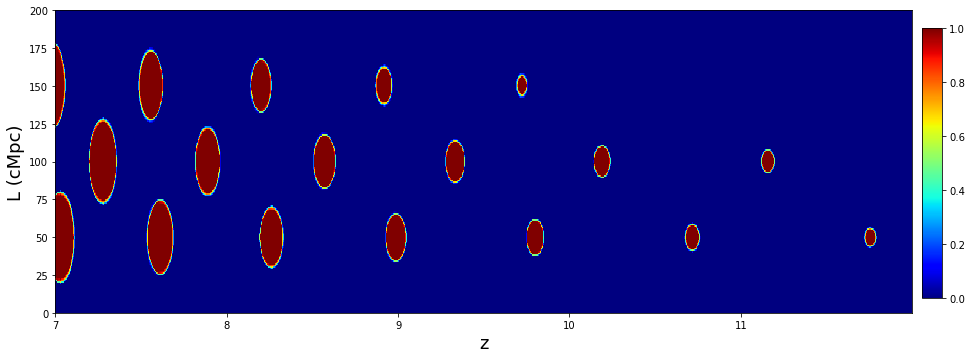

In [8]:
xi = np.array([zs_lc for i in range(xf_lc.shape[1])])
yi = np.array([np.linspace(0,200,xf_lc.shape[1]) for i in range(xi.shape[1])]).T
zj = (xf_lc[100,1:,1:]+xf_lc[100,1:,:-1]+xf_lc[100,:-1,1:]+xf_lc[100,:-1,:-1])/4

fig, axs = plt.subplots(1,1, figsize=(14, 5))
im = axs.pcolor(xi, yi, zj, cmap='jet')
axs.set_xlabel('z', fontsize=18)
axs.set_ylabel('L (cMpc)', fontsize=18)
# axs.set_xticks(np.arange(6.5,13,1))
# axs.set_yticks(np.arange(0,350,100))
fig.subplots_adjust(bottom=0.11, right=0.91, top=0.95, left=0.06)
cax = plt.axes([0.92, 0.15, 0.02, 0.75])
fig.colorbar(im,cax=cax)
#plt.tight_layout()
plt.show()